In [2]:
import matplotlib.pyplot as plt
import numpy as np 
from specutils.manipulation import FluxConservingResampler
import pandas as pd
from uncertainties import unumpy as unp, ufloat
from scipy import constants
from pathlib import Path
from typing import Tuple, List
from functools import partial
from time import time
import concurrent.futures
from tqdm import tqdm

The feture depth is -7.430209341552016e-06 +/- 9.1262573346275e-07 (Rp/Rs)^2
(np.float64(-7.430209341552016e-06), np.float64(9.1262573346275e-07))


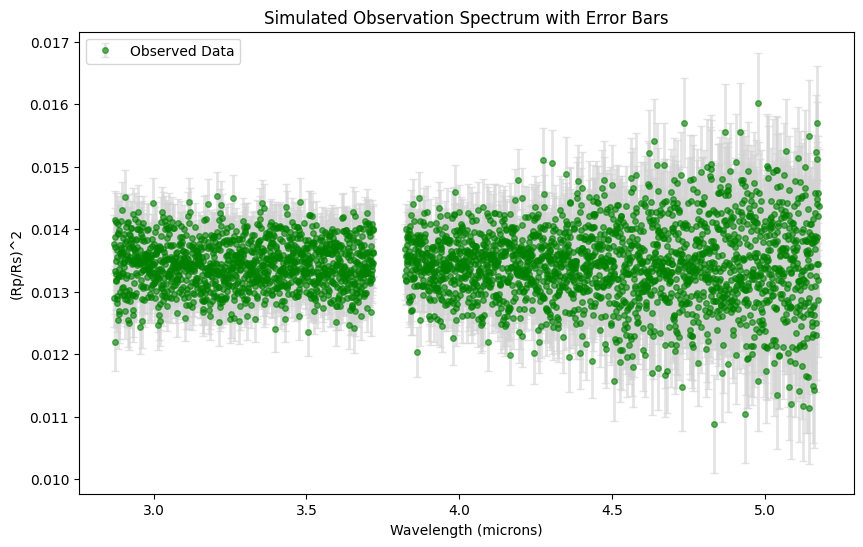

In [ ]:

df = pd.read_csv('Data/composite_exo_data-unfiltered.csv', comment='#')


class PeakFinder:
    def __init__(self):
        self.threshold = 0.5  # example threshold value
        self.feture_top = 5
        self.feture_bottom = 5.4
        self.MAX_WORKERS = 8


    def find_peaks(self, data):
        """This Function takes a spectrun array and looks for a feture depth between two ranges.
        Input is just the data array
        Output is the feture depth and its error bar"""
        mask = data[:, 3] <= 0.001 # take out the bit where the error bars go crazy 
        Proper_datset = data[mask] #data after applying the mask

        Wavelengths= Proper_datset[:,0] # in microns
        Spectrum= Proper_datset[:,2] # data with the noise (Rp/Rs)^2
        error_bars= Proper_datset[:,3] # error bars 

        Top_range_mask= (Wavelengths >= self.feture_top  - self.threshold) & (Wavelengths <= self.feture_top  + self.threshold)
        Bottom_range_mask= (Wavelengths >= self.feture_bottom - self.threshold) & (Wavelengths <= self.feture_bottom + self.threshold)
        Top_range= Spectrum[Top_range_mask]
        Bottom_range= Spectrum[Bottom_range_mask]
        Average_top= np.mean(Top_range)
        Average_bottom= np.mean(Bottom_range)
        Feature_depth= Average_bottom - Average_top
        Top_range_error = error_bars[Top_range_mask]
        Bottom_range_error = error_bars[Bottom_range_mask]
        Top_error= np.sum(Top_range_error**2)/len(Top_range_error)
        Bottom_error= np.sum(Bottom_range_error**2)/len(Bottom_range_error)
        Feature_depth_error= np.sqrt(Top_error**2 + Bottom_error**2)

        print(f"The feture depth is {Feature_depth} +/- {Feature_depth_error} (Rp/Rs)^2")
        return Feature_depth, Feature_depth_error
    

    def Find_A_H(self, peak_height, Error, planet_name):
        R_R = df.loc[df['pl_name'] == planet_name, 'pl_ratror'].values[0][0]  # radius ratio (R_p / R_s)
        R_p = df.loc[df['pl_name'] == planet_name, 'pl_rade'].values[0][0]   # planetary radius in earth radii
        R_s=R_p/R_R # stellar radius in earth radii
        R_p_error = "unknown" # planetary radius error in earth radii
        R_s_error = "unknown" # stellar radius error in earth radii
        g = "unknown"  # surface gravity in m/s^2 need to get from somewhere
        g_error = "unknown"  # surface gravity error in m/s^2
        T_eq = "unknown"   # equilibrium temperature in K need to get from somewhere
        T_eq_error = "unknown"  # equilibrium temperature error in K
        mu = 2.3 # mean molecular weight (assuming H2 dominated atmosphere)
        k_B = constants.physical_constants['Boltzmann constant'][0]  # Boltzmann constant in J/K

        R_p_full = ufloat(R_p, R_p_error)  # Assuming negligible error for radius ratio
        R_s_full = ufloat(R_s, R_s_error)  # Assuming negligible error for radius ratio
        g_full = ufloat(g, g_error)
        T_eq_full = ufloat(T_eq, T_eq_error)
        Peak_height_full = ufloat(peak_height, Error)
        

        # Calculate amplitude A_H
        A_H_full = (Peak_height_full* R_s_full**2 * mu * g_full) / (k_B * T_eq_full * R_p_full)
        A_H_error = A_H_full.s
        A_H = A_H_full.n

        print(f"The amplitude A_H is {A_H_full:2f}")
        return T_eq, T_eq_error,A_H, A_H_error

    def process_file(self, file_path: Path) -> Tuple[Tuple, float]:
        """ This is the function that applies all the quality checks and processes a single file.
        Input is the file path.
        Output is a tuple of results and the time taken to process the file."""
        start_time = time.time()
        try:
            data = np.loadtxt(file_path)
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
            return (None, 0.0) , time.time() - start_time
        
        Feture_depth, Feature_error = self.find_peaks(data)
        planet_name = 'Unknown'  # Placeholder, replace with actual logic to get planet name
        T_eq, T_eq_error, A_H, A_H_error = self.Find_A_H(Feture_depth, Feature_error, planet_name) 

        duration = time.time() - start_time
        return (file_path.name, T_eq, T_eq_error, A_H, A_H_error), duration
    

    def _print_processing_stats(self, num_files: int, total_duration: float, times: List[float]) -> None:
        """Print processing statistics"""
        avg_time = sum(times) / len(times) if times else 0
        print(f"Processed {num_files} files")
        print(f"Total time: {total_duration:.2f} seconds")
        print(f"Average time per file: {avg_time:.3f} seconds")
        print(f"Files per second: {num_files / total_duration:.2f}")


    

    def process_folder(self, folder: Path)-> Tuple[np.ndarray, ...]:
        """This function will take a folder filled with spectra files and process each one to find the peak depths.
        Input is the folder path
        Output is a list of peak depths and their error bars for each file"""
        Spectra_files = []

        # Search for .txt files recursively
        for pattern in ['*.txt']:  # Case insensitive search
            Spectra_files.extend(list(folder.rglob(pattern)))
        
        # Remove duplicates while preserving order
        seen = set()
        unique_files = []
        for f in Spectra_files:
            if f not in seen:
                seen.add(f)
                unique_files.append(f)
        
        Spectra_files = unique_files
        print(f"Found {len(Spectra_files)} .txt files")
        
        if not Spectra_files:
            print("No .txt files found!")
            return tuple()

       
      
        if not Spectra_files:
            print("All files were filtered out!")
            return tuple()
        
        results = []
        times = []
        failed_files = []
        
        process_fn = partial(self.process_file)
        total_start = time.time()
        
        # OPTIMIZATION: Batch processing with memory management
        batch_size = min(1000, len(Spectra_files))  # Process in batches to manage memory
        
        for batch_start in range(0, len(Spectra_files), batch_size):
            batch_end = min(batch_start + batch_size, len(Spectra_files))
            batch_files = Spectra_files[batch_start:batch_end]
            
            print(f"Processing batch {batch_start//batch_size + 1}/{(len(Spectra_files)-1)//batch_size + 1}")
            
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.MAX_WORKERS) as executor:
                futures = [executor.submit(process_fn, file_path) for file_path in batch_files]
                
                for i, future in enumerate(tqdm(concurrent.futures.as_completed(futures), 
                                total=len(batch_files), desc=f"Processing batch")):
                    result, duration = future.result()
                    if result is None:
                        failed_files.append(batch_files[i])
                        continue
                    else:
                        results.append(result)
                        times.append(duration)
        
        
        total_duration = time.time() - total_start
        
        print(f"Successfully processed: {len(results)} files")
        print(f"Failed to process: {len(failed_files)} files")
        
        
        if not results:
            print("No valid data processed.")
            if failed_files:
                print("Sample failed files:")
                for f in failed_files[:5]:
                    print(f"  {f}")
            return tuple()
        
        # Print statistics
        self._print_processing_stats(len(results), total_duration, times)
        
        
        # Unpack results more efficiently
        file_names, T_eq, T_eq_error, A_H , A_H_errors = zip(*results)
        
        # Convert to numpy arrays
        file_names = np.array(file_names, dtype='object')
        T_eq = np.array(T_eq, dtype=np.float64)
        T_eq_error = np.array(T_eq_error, dtype=np.float64)
        A_H = np.array(A_H, dtype=np.float64)
        A_H_errors = np.array(A_H_errors, dtype=np.float64)

        Results_array = np.stack((file_names, T_eq, T_eq_error, A_H , A_H_errors), axis=-1)
        np.savetxt(folder/ "results.txt", Results_array, fmt='%s', header='File_Name T_eq T_eq_error A_H A_H_error')
 
        return Results_array


def main():
    """This is the main function that will execute when the script is run.
    Can change to be whatever you want to run."""
    data= np.loadtxt(r'Data/sim_obs.txt') # load the data 
    mask = data[:, 3] <= 0.001 # take out the bit where the error bars go crazy 
    Proper_datset = data[mask] #data after applying the mask

    Wavelengths= Proper_datset[:,0] # in microns
    Spectrum= Proper_datset[:,2] # data with the noise (Rp/Rs)^2
    error_bars= Proper_datset[:,3] # error bars 

    peak = PeakFinder().find_peaks(data)
    print(peak)


    plt.figure(figsize=(10,6))
    #plt.scatter(Wavelengths, Spectrum)
    plt.errorbar(Wavelengths, Spectrum, yerr=error_bars, fmt='o', label='Observed Data', zorder= 1, alpha=0.6, color='green', ecolor='lightgray', elinewidth=2, capsize=3, markersize=4)
    #plt.ylim(min(data[:,1]), max(data[:,1]))
    plt.xlabel('Wavelength (microns)')
    plt.ylabel('(Rp/Rs)^2')
    plt.title('Simulated Observation Spectrum with Error Bars')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

[0.0778628  0.25979637 0.23142545 0.76026027 0.55768162 0.27294015
 0.13351213 0.48537852 0.31586047 0.91128723]


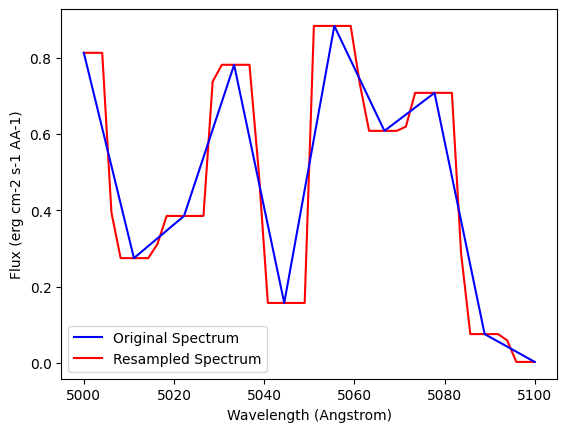

In [58]:
import numpy as np
import astropy.units as u
from specutils import Spectrum
from specutils.manipulation import FluxConservingResampler
import matplotlib.pyplot as plt
print(np.random.random(10))
wave = np.linspace(5000, 5100, 10) * u.AA
#flux = np.random.random(10) * u.Unit("erg cm-2 s-1 AA-1")
flux = np.array([0.81306158, 0.27469256, 0.38526647, 0.78165338, 0.15717256, 0.88356331,
 0.60842991, 0.70807226, 0.07552976, 0.00253725]) * u.Unit("erg cm-2 s-1 AA-1")
spec = Spectrum(spectral_axis=wave, flux=flux)
new_wave = np.linspace(5000, 5100, 50) * u.AA
resampler = FluxConservingResampler()
new_spec = resampler(spec, new_wave)

plt.plot(spec.spectral_axis, spec.flux, zorder= 2, label='Original Spectrum', color='blue')
plt.xlabel("Wavelength (Angstrom)") 
plt.plot(new_spec.spectral_axis, new_spec.flux, label='Resampled Spectrum', color='red', zorder= 1)
plt.ylabel("Flux (erg cm-2 s-1 AA-1)")
plt.legend()
plt.show()

In [8]:
x= ufloat(5,0)
y= ufloat(3,2)
2*y

c:\Users\Miles\AppData\Local\Programs\Python\Python312\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


6.0+/-4.0

In [8]:
array1= np.array(['apple', 'banana', 'cherry'])
array2= np.array([1,2,3])
array_full= np.stack((array1, array2), axis=-1)
print(array_full[1,0])
    

banana
